In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import trange

from flygym.mujoco import Parameters

from nmf_grooming import (
    NeuromechflyGrooming,
    all_groom_dofs,
    load_grooming_data,
    plot_state_and_contacts,
)
from scipy.signal import find_peaks, medfilt

In this exercise session, we will explore the concept of hierarchical control. We will do so by focusing on grooming a behavior commonly observed in flies and that can be experimentally induced using optogenetics or by dusting. There are different grooming behaviours targeting different body parts such as antenna, foreleg or head grooming. Each of those sub-behaviours can be seen as a module that, when put together, give rise to a grooming sequence. As demonstrated in the Seed et al paper, the grooming sequence reflects it's underlying hierarchy. During this week's exercise session, we will focus on left antenna, right antenna, head and foreleg grooming.

The first notebook focuses on the extraction of grooming modules from a recorded grooming sequence and the looping of those modules in a coherent sequence.

# Exercise 1: Extracting grooming modules

In this exercise we will use the recording of a real fly grooming recorded by Gizem Özdil in our lab:

<p float="left">
    <video align="center" width="700" controls>
    <source src="source/camera_3_cut.mp4" type="video/mp4">
    </video>
    <video align="center" width="700" controls>
    <source src="source/camera_1_cut.mp4" type="video/mp4">
    </video>
</p>

 For convenience, we provided you with the data in joint angle space and will use NeuroMechFly to perform the forward kinematics (get positions in cartesian space). Note that the data provided has been extracted from a recording of the fly. The recording is obtained with multiple videos from them, the 2D pose of the fly is estimated and triangulated in a 3D pose. From the 3D pose with obtain the joint angles using inverse kinematics.

Let's load the joint angles for grooming and visualize how they unroll.

In [2]:
timestep = 1e-4
data_block = load_grooming_data("./data/grooming_sequence.pkl", timestep)

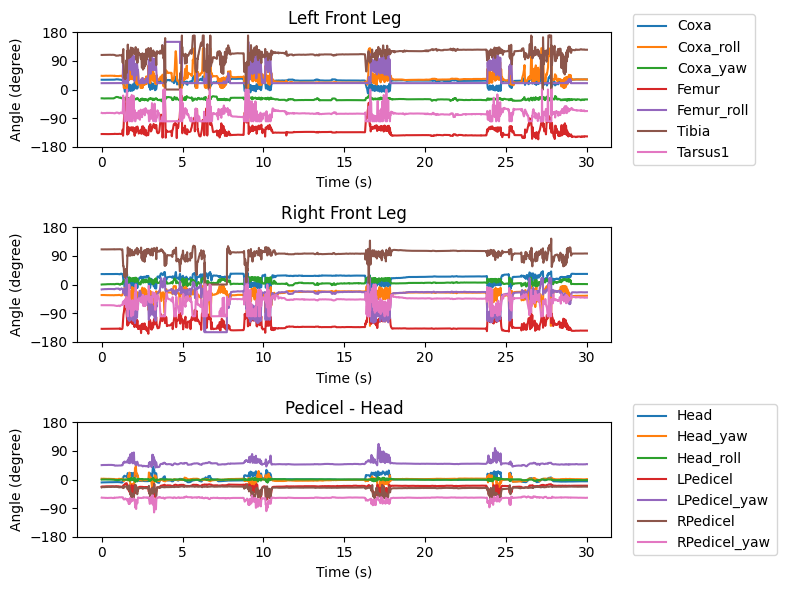

In [3]:
def plot_grooming_kinematics(data_block, t):
    fig, axs = plt.subplots(3, 1, figsize=(8, 6))

    appendages = [
        f"{side} {pos}" for pos in ["Front Leg"] for side in ["Left", "Right"]
    ] + ["Pedicel - Head"]

    for i, app in enumerate(appendages):
        ax = axs.flatten()[i]
        app_code = f"{app.split()[0][0]}{app.split()[1][0]}".upper()
        for j, dof in enumerate(all_groom_dofs):
            if app_code in dof:
                ax.plot(t, np.rad2deg(data_block[j, :]), label=dof[8:])
            elif not "Leg" in app and ("Head" in dof or "Pedicel" in dof):
                ax.plot(t, np.rad2deg(data_block[j, :]), label=dof[6:])
            else:
                continue
        ax.set_ylim(-180, 180)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Angle (degree)")
        ax.set_yticks([-180, -90, 0, 90, 180])
        ax.set_title(app)
        if i == 0 or i == 2:
            ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)

    plt.tight_layout()
    return fig


experiment_time = np.arange(0, data_block.shape[1] * timestep, timestep)
fig = plot_grooming_kinematics(data_block, experiment_time)

The full recording is 30sec long, we are not going to replay the whole recording. Let's try to select the most interesting and diverse piece of data to replay.

We are looking for antennal and foreleg grooming. What kind of coordination/ joint angles would you expect ?

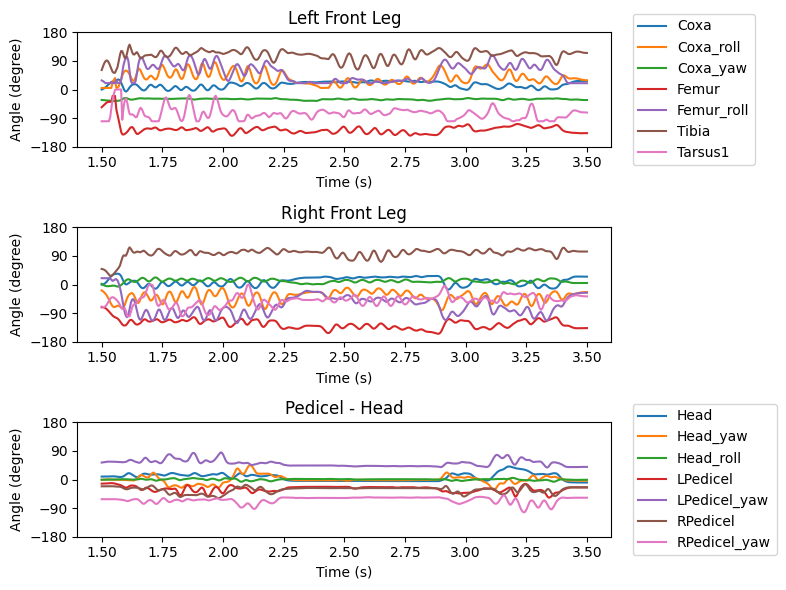

In [4]:
start_time = 1.5
end_time = 3.5
start_idx = int(start_time / timestep)
end_idx = int(end_time / timestep)
data_block_focus = data_block[:, start_idx:end_idx]
time_focus = experiment_time[start_idx:end_idx]

fig = plot_grooming_kinematics(data_block_focus, time_focus)

In [5]:
target_num_steps = end_idx - start_idx

sim_params = Parameters(
    timestep=timestep,
    render_mode="saved",
    render_playspeed=0.1,
    draw_contacts=False,
    actuator_kp=10.0,
    render_camera="Animat/camera_front",
)
nmf = NeuromechflyGrooming(sim_params=sim_params)
obs, info = nmf.reset()

obs_list = []

for i in trange(target_num_steps):
    # here, we simply use the recorded joint angles as the target joint angles
    joint_pos = data_block_focus[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()
    obs_list.append(obs)

Path("outputs/").mkdir(exist_ok=True)
nmf.save_video("outputs/grooming_kinematic_replay.mp4", 0)

100%|██████████| 20000/20000 [00:11<00:00, 1787.87it/s]


In [6]:
# For the sake of simplicity we fix the antenna (motion in the antenna is hard to monitor as it might be caused by the grooming action or voluntary by the fly)
Rantenna_pitch_idx = nmf.actuated_joints.index("joint_RPedicel")
Lantenna_pitch_idx = nmf.actuated_joints.index("joint_LPedicel")
Rantenna_yaw_idx = nmf.actuated_joints.index("joint_RPedicel_yaw")
Lantenna_yaw_idx = nmf.actuated_joints.index("joint_LPedicel_yaw")

antenna_pitch_mean_pos = np.mean(
    data_block_focus[[Rantenna_pitch_idx, Lantenna_pitch_idx], :]
)
antenna_yaw_mean_pos = np.mean(
    data_block_focus[[Rantenna_yaw_idx, Lantenna_yaw_idx], :] * [[-1], [1]]
)
data_block_focus[Rantenna_pitch_idx, :] = antenna_pitch_mean_pos
data_block_focus[Lantenna_pitch_idx, :] = antenna_pitch_mean_pos
data_block_focus[Rantenna_yaw_idx, :] = -1 * antenna_yaw_mean_pos
data_block_focus[Lantenna_yaw_idx, :] = antenna_yaw_mean_pos

## Extract grooming modules

### Antennal grooming

During antennal grooming the legs mostly move in the z-y plane and one grooming sweep is an ellipse in that plane.

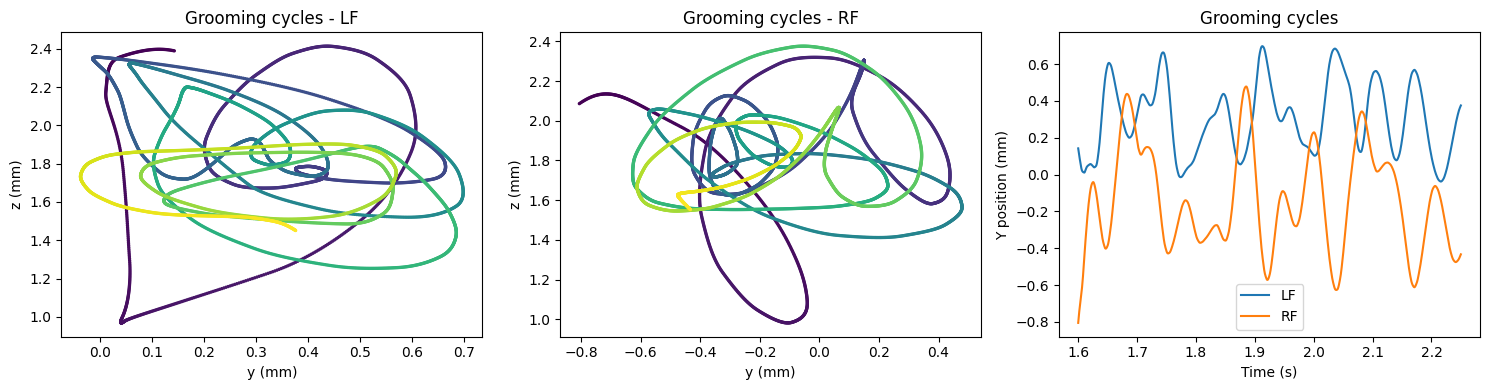

In [7]:
################################################################
# TODO: Explore the format of end_effector observations obs["end_effectors"]
#       extract the positions of the end effectors of the front legs.
#       the dimension of foreleg_end_effector_positions should be (2, num_steps, 3)
# TIPS: The end effectors sensors are placed at the tips of the last tarsal segment of each leg whose names are stored in nmf._last_tarsalseg_names
frontleg_tips = ("LF", "RF")
foreleg_end_effector_id = ...
foreleg_end_effector_positions = ...
################################################################

# based on the video and the plotted joint angles we can identify the grooming cycles
ant_grooming_start_t = 1.6
ant_grooming_end_t = 2.25
ant_grooming_start_idx = (
    int(ant_grooming_start_t / sim_params.timestep) - start_idx
)  # timepoints are given in global time
ant_grooming_end_idx = int(ant_grooming_end_t / sim_params.timestep) - start_idx

ant_grooming_frontlegs_end_effector_positions = foreleg_end_effector_positions[
    :, ant_grooming_start_idx:ant_grooming_end_idx
]

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

j = 0
for i, ee_pos in enumerate(ant_grooming_frontlegs_end_effector_positions):
    # Use scatter to have a change in color as time progresses
    axs[i].scatter(
        ee_pos[:, 1],
        ee_pos[:, 2],
        label=frontleg_tips[i],
        s=2,
        c=np.arange(len(ee_pos[:, 1])),
        cmap="viridis",
    )
    axs[i].set_xlabel("y (mm)")
    axs[i].set_ylabel("z (mm)")
    axs[i].set_title("Grooming cycles - " + frontleg_tips[i])

axs[2].plot(
    time_focus[ant_grooming_start_idx:ant_grooming_end_idx],
    ant_grooming_frontlegs_end_effector_positions[:, :, 1].T,
)
axs[2].set_xlabel("Time (s)")
axs[2].set_ylabel("Y position (mm)")
axs[2].set_title("Grooming cycles")
axs[2].legend(frontleg_tips)
plt.tight_layout()

If everything is right, the plot should look like this:

<img src="source/antennal_grooming_visualization.png" width="1500">

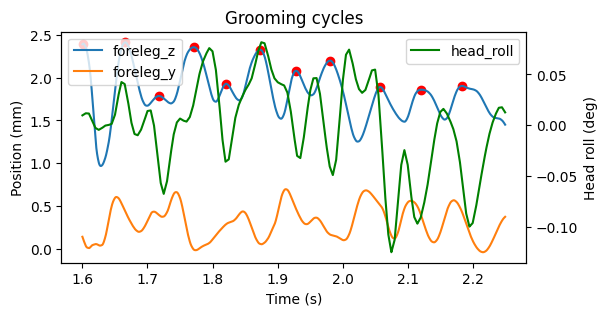

In [8]:
################################################################
# TODO: Extract all the peaks of the z position of the front legs end effectors to segment grooming cycles
peaks, _ = ...
################################################################

# Look at the z position to segment grooming cycles
ant_grooming_time = time_focus[ant_grooming_start_idx:ant_grooming_end_idx]

ax, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.plot(
    ant_grooming_time,
    ant_grooming_frontlegs_end_effector_positions[0, :, 2],
    label="foreleg_z",
)
ax.scatter(
    ant_grooming_time[peaks],
    ant_grooming_frontlegs_end_effector_positions[0, :, 2][peaks],
    c="r",
)
ax.plot(
    ant_grooming_time,
    ant_grooming_frontlegs_end_effector_positions[0, :, 1],
    label="foreleg_y",
)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Position (mm)")
ax.set_title("Grooming cycles")

twin_ax = ax.twinx()
head_roll_idx = all_groom_dofs.index("joint_Head_roll")
head_roll = data_block_focus[head_roll_idx, ant_grooming_start_idx:ant_grooming_end_idx]
twin_ax.plot(ant_grooming_time, head_roll, c="g", label="head_roll")
twin_ax.set_ylabel("Head roll (deg)")
ax.legend(loc="upper left")
twin_ax.legend(loc="upper right")

plt.show()

In [9]:
# Pick the best grooming cycle e.g. the head roll seems to return to the same position
ant_cycle_grooming_start = peaks[-2] + ant_grooming_start_idx
ant_cycle_grooming_end = peaks[-1] + ant_grooming_start_idx

data_block_ant_grooming = data_block_focus[
    :, ant_cycle_grooming_start:ant_cycle_grooming_end
]

In [10]:
def make_cyclical(
    data, closure_window_size=int(200 / 1e-4 * timestep), smooth_half_window_size=2
):
    # helper function to loop an extract of the data
    # The idea here is to close the data and smoothen the trace to make the transition smooth

    # close the data by interpolating between zeros and the difference between the first and last value in a closure window
    diff = data[:, 0] - data[:, -1]
    diff_ramp = np.linspace(0, diff, closure_window_size).T
    data_closed = data.copy()
    data_closed[:, -closure_window_size:] += diff_ramp

    # median_filter just to smooth the transition
    smooth_window_size = 2 * smooth_half_window_size + 1
    data_looped_expanded = np.concatenate(
        [
            data_closed[:, -smooth_half_window_size:],
            data_closed,
            data_closed[:, :smooth_half_window_size],
        ],
        axis=1,
    )
    data_cyclic = medfilt(data_looped_expanded, kernel_size=(1, smooth_window_size))[
        :, smooth_half_window_size:-smooth_half_window_size
    ]

    return data_cyclic

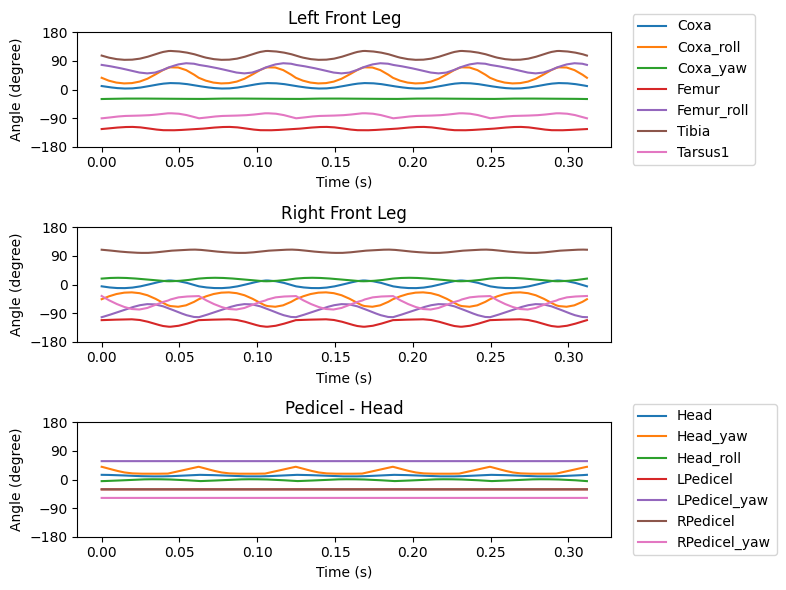

In [11]:
# plot the cycled data
n_cycles = 5
data_block_ant_grooming_smoothed = make_cyclical(data_block_ant_grooming)
data_block_ant_grooming_interp_cycled = np.tile(
    data_block_ant_grooming_smoothed, n_cycles
)

time = np.arange(len(data_block_ant_grooming_interp_cycled[0])) * sim_params.timestep
cycle_length = len(data_block_ant_grooming[0])

fig = plot_grooming_kinematics(data_block_ant_grooming_interp_cycled, time)

In [12]:
# replay the cycled grooming
obs, info = nmf.reset()

target_num_steps = data_block_ant_grooming_interp_cycled.shape[1]

for i in trange(target_num_steps):
    joint_pos = data_block_ant_grooming_interp_cycled[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

# as the left antenna is groomed, we call it left antennal grooming
nmf.save_video("outputs/grooming_antennal_R_looped.mp4", 0)

100%|██████████| 3120/3120 [00:01<00:00, 1691.62it/s]


### Mirror the grooming behavior to get right antennal grooming

In [13]:
################################################################
# TODO: Mirror the antennal grooming to the left antenna
# TIPS: Mirror every leg, head and antenna joints. Note that yaw and roll have a different
#       sign if they are applied to the left or right legs. Inspect carefully the traces above
#       and visualize the videos to access the mirroring.
data_block_ant_grooming_smoothed_mirrored = np.zeros_like(
    data_block_ant_grooming_smoothed
)
for i, joint in enumerate(nmf.actuated_joints):
    ...
################################################################

In [14]:
obs, info = nmf.reset()

data_block_ant_grooming_interp_cycled_mirrored = np.tile(
    data_block_ant_grooming_smoothed_mirrored, n_cycles
)
target_num_steps = data_block_ant_grooming_interp_cycled_mirrored.shape[1]

for i in trange(target_num_steps):
    joint_pos = data_block_ant_grooming_interp_cycled_mirrored[:, i]
    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)
    nmf.render()

nmf.save_video("outputs/grooming_antennal_L_looped.mp4", 0)

100%|██████████| 3120/3120 [00:01<00:00, 1753.43it/s]


# Exercise 2: Transitions between modules

Now that we have isolated grooming modules the goal is to bind them together and come up with a strategy to generate transitions between modules.

In [15]:
# Load grooming modules extracted in the notebook Extract_other_modules.ipynb

grooming_module_path = Path("./data/grooming_modules_provided_slow.pkl")
with open(grooming_module_path, "rb") as f:
    grooming_modules = pickle.load(f)

timestep = grooming_modules["timestep"]

In [16]:
sim_params = Parameters(
    timestep=timestep,
    render_mode="saved",
    render_playspeed=0.1,
    draw_contacts=False,
    actuator_kp=10.0,
    render_camera="Animat/camera_front",
)

run_time = 1.0
target_num_steps = int(run_time / timestep)

nmf = NeuromechflyGrooming(
    sim_params=sim_params,
    groom_collision=True,
    touch_sensor_locations=[
        "RPedicel",
        "LPedicel",
        "RFuniculus",
        "LFuniculus",
        "RArista",
        "LArista",
        "LFTarsus1",
        "RFTarsus1",
        "LFTarsus2",
        "RFTarsus2",
        "LFTarsus3",
        "RFTarsus3",
        "LFTarsus4",
        "RFTarsus4",
        "LFTarsus5",
        "RFTarsus5",
        "LFTibia",
        "RFTibia",
        "REye",
        "LEye",
    ],
)


np.random.seed(0)

obs_list = []
obs, info = nmf.reset()
obs_list.append(obs)

module_len = {
    module: len(grooming_modules[module][0])
    for module in grooming_modules
    if module != "timestep"
}

transition_period = 500 / 1e-4 * timestep
transit_to = ["L_antenna", "foreleg", "L_antenna", "eyes", "foreleg", "R_antenna"]
transit_times = [0, 1000, 2000, 4000, 5000, 7500]

k = 0

get_transition_joint_angles = lambda before, after, k: before + (after - before) * min(
    1, (k / transition_period)
)

modules = []

for i in trange(target_num_steps):
    ################################################################
    # TODO: Set the next action.
    # NOTE: We would like the transitions to be smooth so that the fly does
    # not perform abrupt movements. The joint angles should be interpolated
    # between the supposed joint angles and the pose at the transition.
    # Do not forget to let the grooming module loop as they only represent
    # a single grooming cycle
    if i in transit_times:
        k = 1
        curr_module = ...
        print(f"Transit to {curr_module}")
        before_transition_pose = ...
    else:
        k += 1

    target_joint_angles = grooming_modules[curr_module][:, k % module_len[curr_module]]
    joint_pos = get_transition_joint_angles(...)
    ################################################################

    action = {"joints": joint_pos}
    obs, reward, terminated, truncated, info = nmf.step(action)

    obs_list.append(obs)
    modules.append(curr_module)

    nmf.render()

modules.append(curr_module)
nmf.save_video("outputs/grooming_sequence.mp4", 0)

  0%|          | 1/10000 [00:00<28:07,  5.92it/s]

Transit to L_antenna


 11%|█▏        | 1140/10000 [00:03<00:14, 605.23it/s]

Transit to foreleg


 21%|██        | 2095/10000 [00:04<00:13, 573.27it/s]

Transit to L_antenna


 40%|████      | 4032/10000 [00:12<00:38, 154.30it/s]

Transit to eyes


 51%|█████     | 5054/10000 [00:17<00:32, 152.39it/s]

Transit to foreleg


 76%|███████▌  | 7597/10000 [00:22<00:04, 581.50it/s]

Transit to R_antenna


100%|██████████| 10000/10000 [00:29<00:00, 336.71it/s]


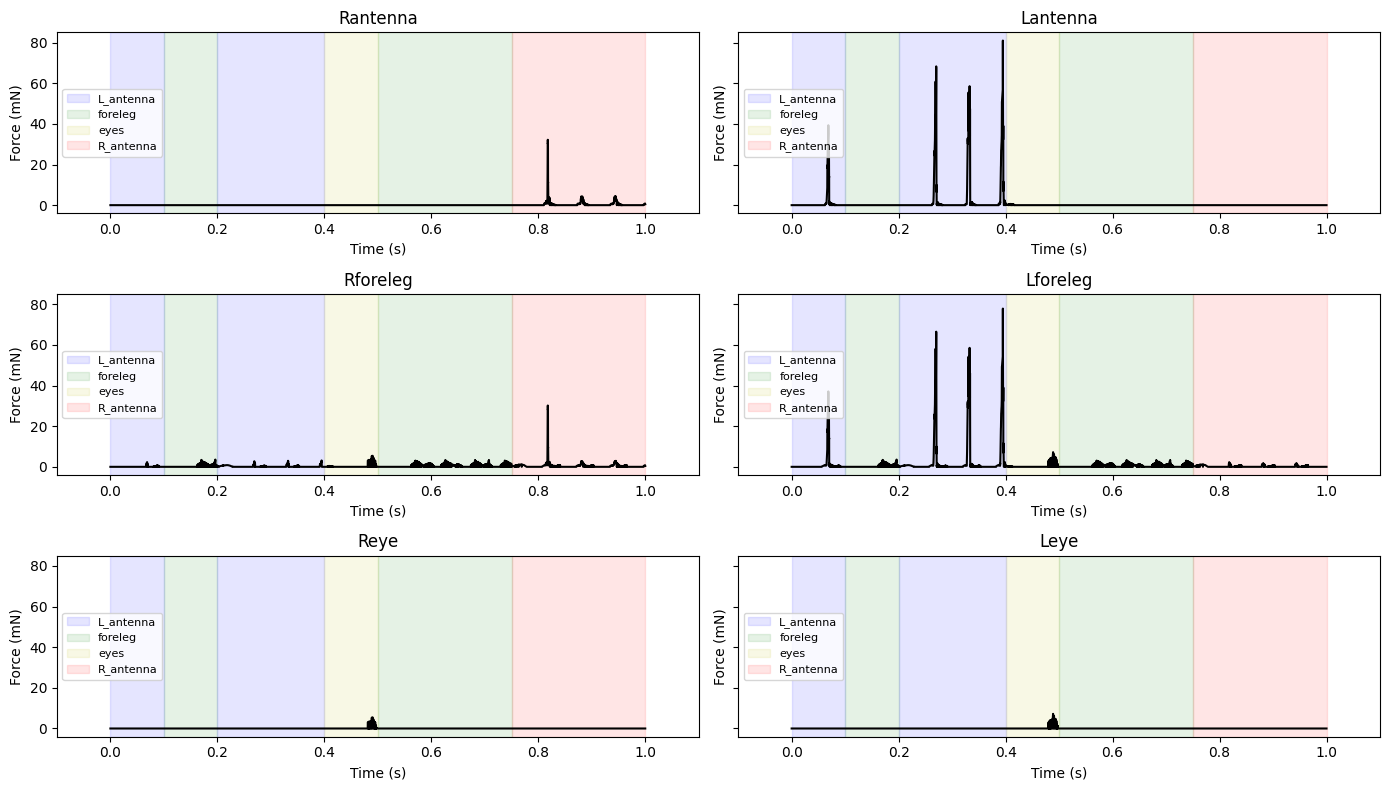

In [17]:
# plot touch sensor traces
touch_sensor_data = np.array([obs["touch_sensors"] for obs in obs_list])
time = np.arange(touch_sensor_data.shape[0]) * sim_params.timestep
fig, _ = plot_state_and_contacts(
    time, touch_sensor_data, nmf.touch_sensor_locations, transit_to, transit_times
)